In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
from pathlib import Path

# Add project root to path
proj_root = Path.cwd().parent.parent
sys.path.insert(0, str(proj_root))

# Import test ingestion tools
from dynamat.mechanical.shpb.io import (
    SpecimenLoader,
    SHPBTestWriter,
    SHPBTestMetadata,
    CSVDataHandler
)

# Import SHPB analysis toolkit
from dynamat.mechanical.shpb import PulseDetector, PulseAligner, StressStrainCalculator, TukeyWindow

# Import ontology tools for RDF graph querying
from dynamat.ontology import OntologyManager
from dynamat.ontology.qudt.qudt_manager import QUDTManager

## Specimen Selection

In [4]:
# Create ontology manager
ontology_manager = OntologyManager()
qudt_manager = QUDTManager()

# Create specimen loader
specimen_loader = SpecimenLoader(ontology_manager)

# Load specimen files from the specimens directory
files_loaded = specimen_loader.load_specimen_files()
print(f"Total specimen files loaded: {files_loaded}")

specimens = specimen_loader.find_specimens(material_name="dyn:SS316_A356")

if specimens:
    for idx, specimen in enumerate(specimens):
        print(f" {idx} - {specimen['id']}")
    print(f"\nTotal specimens: {len(specimens)}")
else:
    print("No specimens found.")


Total specimen files loaded: 162
 0 - DYNML-SS316A356-0001
 1 - DYNML-SS316A356-0002
 2 - DYNML-SS316A356-0003
 3 - DYNML-SS316A356-0004
 4 - DYNML-SS316A356-0005
 5 - DYNML-SS316A356-0006
 6 - DYNML-SS316A356-0007
 7 - DYNML-SS316A356-0008
 8 - DYNML-SS316A356-0009
 9 - DYNML-SS316A356-0010
 10 - DYNML-SS316A356-0011
 11 - DYNML-SS316A356-0012
 12 - DYNML-SS316A356-0013
 13 - DYNML-SS316A356-0014
 14 - DYNML-SS316A356-0015
 15 - DYNML-SS316A356-0016
 16 - DYNML-SS316A356-0017
 17 - DYNML-SS316A356-0018
 18 - DYNML-SS316A356-0019
 19 - DYNML-SS316A356-0020
 20 - DYNML-SS316A356-0021
 21 - DYNML-SS316A356-0022
 22 - DYNML-SS316A356-0023
 23 - DYNML-SS316A356-0024
 24 - DYNML-SS316A356-0025
 25 - DYNML-SS316A356-0026
 26 - DYNML-SS316A356-0027
 27 - DYNML-SS316A356-0028
 28 - DYNML-SS316A356-0029
 29 - DYNML-SS316A356-0030
 30 - DYNML-SS316A356-0031
 31 - DYNML-SS316A356-0032
 32 - DYNML-SS316A356-0033
 33 - DYNML-SS316A356-0034
 34 - DYNML-SS316A356-0035
 35 - DYNML-SS316A356-0036
 36 -

In [89]:
# Select a specific specimen and load its detailed data
if specimens and len(specimens) > 0:
    # Select the first specimen for demonstration
    selected_specimen = specimens[2]
    
    specimen_id = selected_specimen['id']
    specimen_uri = selected_specimen['uri']
    
    print(f"Selected Specimen: {specimen_id}")
    
    # Get detailed specimen data with formatted printing
    specimen_data = specimen_loader.get_specimen_data(specimen_uri, print_data=False)
    
    # Store the specimen data for later use in SHPB analysis
    specimen_data = specimen_data
    SPECIMEN_URI = specimen_uri
    specimen_id = specimen_id
    
    print(f"\nSpecimen data stored in specimen_data variable")
    
else:
    print("No specimens available.")
    print("Please create specimens using the GUI first, then re-run this notebook.")
    specimen_data = None
    SPECIMEN_URI = None
    specimen_id = None

Selected Specimen: DYNML-SS316A356-0003

Specimen data stored in specimen_data variable


## Raw Data Loading

In [90]:
# Load raw SHPB data from CSV file
csv_file_path = Path(r"D:\SHPB Data_Clean\ExperimentData\SS316A356\SS316A356_003.txt")  # UPDATE THIS PATH
raw_df = pd.read_csv(csv_file_path, sep="\t", header=1) 
#raw_df = pd.read_csv(csv_file_path, sep=",", header=1) # DYN: This is user input in GUI
raw_df.rename(columns={"(ms)": "time", "(V)":"incident", "(V).1":"transmitted"}, inplace=True)

# Load the CSV
print(f"Loaded raw data from: {csv_file_path}")
print(f"DataFrame shape: {raw_df.shape}")
print(f"\nColumns: {list(raw_df.columns)}")
print(f"\nFirst few rows:")
print(raw_df.head())

# Validate the DataFrame structure
handler = CSVDataHandler(raw_df)
try:
    handler.validate_structure()
    print("\nDataFrame validation: PASSED")
except ValueError as e:
    print(f"\nDataFrame validation: FAILED")
    print(f"Error: {e}")

Loaded raw data from: D:\SHPB Data_Clean\ExperimentData\SS316A356\SS316A356_003.txt
DataFrame shape: (160004, 3)

Columns: ['time', 'incident', 'transmitted']

First few rows:
       time  incident  transmitted
0 -0.400021 -0.003663    -0.004578
1 -0.400009 -0.003663    -0.004578
2 -0.399996 -0.003663    -0.004578
3 -0.399984 -0.003663    -0.004578
4 -0.399971 -0.003663    -0.004578

DataFrame validation: PASSED


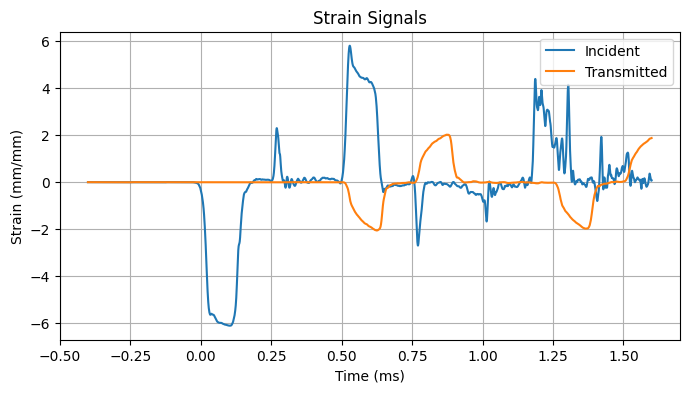

In [91]:
plt.figure(figsize=(8,4))
plt.plot(raw_df["time"], raw_df["incident"], label = "Incident")
plt.plot(raw_df["time"], raw_df["transmitted"], label = "Transmitted")
plt.title(f"Strain Signals")
plt.xlabel("Time (ms)")
plt.ylabel("Strain (mm/mm)")
plt.legend()
plt.grid()
plt.show()

## Equipment Metadata Extraction

In [92]:
# Create SHPB test metadata with equipment URIs
test_date = "2025-04-25"  # UPDATE THIS
test_id = f"{specimen_id}_SHPBTest"

print(f"Creating test metadata for: {test_id}")
print("=" * 60)

# Create minimal metadata object
test_metadata = SHPBTestMetadata(
  test_id=test_id,
  specimen_uri=SPECIMEN_URI,
  test_date=test_date,
  user="dyn:User_ErwinCazares",  # UPDATE THIS

  # Required Equipment URIs (from mechanical_testing_individuals.ttl)
  striker_bar_uri="dyn:StrikerBar_C350_12in_0375in",      # CHANGE THIS
  incident_bar_uri="dyn:IncidentBar_C350_8ft_0375in",
  transmission_bar_uri="dyn:TransmissionBar_C350_6ft_0375in",
  incident_strain_gauge_uri="dyn:StrainGauge_SHPB_001",
  transmission_strain_gauge_uri="dyn:StrainGauge_SHPB_002",

  # Optional equipment
  momentum_trap_uri="dyn:MomentumTrap_TailoredGap",  # or dyn:MomentumTrap_Full, TailoredGap
  pulse_shaper_uri="dyn:PulseShaper_Copper_0025in",  # dyn:PulseShaper_Copper_0015in, _0020in, _0025in

  # Test conditions (measurements with units)
  striker_velocity={'value': 23.02, 'unit': 'unit:M-PER-SEC', 'reference_unit': 'unit:M-PER-SEC'},
  striker_launch_pressure={'value': 40, 'unit': 'unit:PSI', 'reference_unit': 'unit:PSI'},
  barrel_offset={'value': 19.05, 'unit': 'unit:MilliM', 'reference_unit': 'unit:MilliM'},
  momentum_trap_distance={'value': 1.5, 'unit': 'unit:MilliM', 'reference_unit': 'unit:MilliM'},
  lubrication_applied=True
)

# Validate metadata
try:
    test_metadata.validate()
    print("Metadata validation: PASSED")
except ValueError as e:
    print(f"Metadata validation: FAILED - {e}")

print(f"Test ID: {test_metadata.test_id}")
print(f"Specimen: {test_metadata.specimen_uri}")
print(f"Date: {test_metadata.test_date}")
print(f"User: {test_metadata.user}")


Creating test metadata for: DYNML-SS316A356-0003_SHPBTest
Metadata validation: PASSED
Test ID: DYNML-SS316A356-0003_SHPBTest
Specimen: https://dynamat.utep.edu/ontology#DYNML_SS316A356_0003
Date: 2025-04-25
User: dyn:User_ErwinCazares


In [93]:
# Extract equipment properties from ontology
print("Extracting equipment properties from ontology...")
print("=" * 60)

# Extract all equipment properties in one call
equipment = test_metadata.extract_all_equipment_properties(specimen_loader)

# Display extracted properties
# Store critical values for SHPB analysis

# Bar material properties
bar_cross_section = equipment['incident_bar']['cross_section']  # mm2
bar_wave_speed = equipment['incident_bar']['wave_speed']  # m/s
bar_elastic_modulus = equipment['incident_bar']['elastic_modulus']
bar_density = equipment['incident_bar']['density']
striker_length = equipment["striker_bar"]["length"]
striker_velocity = test_metadata.striker_velocity['value']

# Specimen properties
specimen_cross_section = specimen_data['dimensions']['hasOriginalCrossSection']
specimen_cross_section_def = specimen_data['dimensions']['hasFinalCrossSection']
specimen_height = specimen_data['dimensions']['hasOriginalHeight']
specimen_height_def = specimen_data['dimensions']['hasFinalHeight']

#Strain Gauge Factors
incident_reflected_gauge_params={
    'gauge_res': equipment["incident_gauge"]["gauge_resistance"],
    'gauge_factor': equipment["incident_gauge"]["gauge_factor"],
    'cal_voltage': equipment["incident_gauge"]["calibration_voltage"],
    'cal_resistance': equipment['incident_gauge']["calibration_resistance"]}

transmitted_gauge_params={
    'gauge_res': equipment["transmission_gauge"]["gauge_resistance"],
    'gauge_factor': equipment["transmission_gauge"]["gauge_factor"],
    'cal_voltage': equipment["transmission_gauge"]["calibration_voltage"],
    'cal_resistance': equipment["transmission_gauge"]["calibration_resistance"]
}


print(f"="*60)
print("Equipment properties extracted successfully!")
print("Ready for SHPB analysis with:")
print(f"  Bar cross-section: {bar_cross_section} mm2")
print(f"  Bar wave speed: {bar_wave_speed} m/s")
print(f"  Bar Elastic Modulus: {bar_elastic_modulus / 1000} GPa")
print(f"  Specimen cross-section: {specimen_cross_section} mm2")
print(f"  Specimen height: {specimen_height} mm")


Extracting equipment properties from ontology...
Equipment properties extracted successfully!
Ready for SHPB analysis with:
  Bar cross-section: 71.25574 mm2
  Bar wave speed: 4953.321 m/s
  Bar Elastic Modulus: 199.99 GPa
  Specimen cross-section: 32.16991 mm2
  Specimen height: 6.4 mm


## Pulse Analysis Section

In [94]:
# Calculate pulse duration in data points
pulse_duration_ms = (2 * striker_length ) / bar_wave_speed          # duration (ms) = 2L / C_bar
pulse_length = 2 * striker_length
dt = np.median(np.diff(raw_df["time"])).astype("float")  # sampling interval in ms
pulse_pts = int(pulse_duration_ms / dt)

print(f"Pulse duration: {pulse_duration_ms} ms")
print(f"Pulse length: {pulse_length} mm")
print(f"Sampling interval: {dt:.6f} ms")
print(f"Pulse points: {pulse_pts}")

# Pulse properties
pulse_stress_amplitude = (0.5 * bar_density * bar_wave_speed * striker_velocity ) / 1000
pulse_strain_amplitude = 0.5 * (striker_velocity / bar_wave_speed)

print(f"Pulse stress amplitude: {pulse_stress_amplitude:.2f} MPa")
print(f"Pulse strain amplitude: {pulse_strain_amplitude:.3e} mm/mm")

# Create detector with configuration
detector = PulseDetector(
    pulse_points=pulse_pts,
    k_trials=(5000, 2000, 1000),  # Try multiple thresholds               # DYN: GUI should allow k_trials if needed
    polarity="compressive",
    min_separation=int(0.8 * pulse_pts)
)

print(f"\nPulseDetector initialized:")
print(f"  Template polarity: {detector.polarity}")
print(f"  Min separation: {detector.min_separation} samples")

Pulse duration: 0.12306894707611318 ms
Pulse length: 609.6 mm
Sampling interval: 0.000012 ms
Pulse points: 9845
Pulse stress amplitude: 460.81 MPa
Pulse strain amplitude: 2.324e-03 mm/mm

PulseDetector initialized:
  Template polarity: compressive
  Min separation: 7876 samples


In [95]:
# Store calculated pulse properties in metadata
test_metadata.pulse_duration = {
    'value': pulse_duration_ms,
    'unit': 'unit:MilliSEC',
    'reference_unit': 'unit:MilliSEC'
}
test_metadata.pulse_length = {
    'value': pulse_length,
    'unit': 'unit:MilliM',
    'reference_unit': 'unit:MilliM'
}
test_metadata.pulse_stress_amplitude = {
    'value': pulse_stress_amplitude,
    'unit': 'unit:MegaPA',
    'reference_unit': 'unit:MegaPA'
}
test_metadata.pulse_strain_amplitude = pulse_strain_amplitude  # Unitless
test_metadata.sampling_interval = {
    'value': dt * 1000,  # Convert ms to μs
    'unit': 'unit:MicroSEC',
    'reference_unit': 'unit:MicroSEC'
}

print(f"\nPulse properties stored in metadata:")
print(f"  Duration: {test_metadata.pulse_duration['value']:.4f} ms")
print(f"  Length: {test_metadata.pulse_length['value']:.2f} mm")
print(f"  Stress amplitude: {test_metadata.pulse_stress_amplitude['value']:.2f} MPa")
print(f"  Strain amplitude: {test_metadata.pulse_strain_amplitude:.3e}")


Pulse properties stored in metadata:
  Duration: 0.1231 ms
  Length: 609.60 mm
  Stress amplitude: 460.81 MPa
  Strain amplitude: 2.324e-03


## Determine Pulse Windows

In [96]:
# Define search bounds to ignore noise regions
# These bounds should be adjusted based on your experimental setup
LB = 10000   # lower bound - start searching after this index                               # DYN: GUI should allow setting UB and LB if needed
UB = 50000  # upper bound - stop searching before this index

# Detect incident pulse
print("Detecting incident pulse...")
incident_window = detector.find_window(
    raw_df["incident"].values,
    lower_bound=LB,
    upper_bound=UB,  # Incident comes first
    metric="median",
    debug=True
)
print(f"Incident window: {incident_window}")

# Store incident pulse detection metadata
test_metadata.incident_pulse_points = int(detector.pulse_points)
test_metadata.incident_k_trials = ','.join(map(str, detector.k_trials))
test_metadata.incident_polarity = detector.polarity
test_metadata.incident_min_separation = detector.min_separation
test_metadata.incident_lower_bound = int(LB)
test_metadata.incident_upper_bound = int(UB)
test_metadata.incident_detection_metric = "median"
test_metadata.incident_window_start = int(incident_window[0])
test_metadata.incident_window_end = int(incident_window[1])
test_metadata.incident_window_length = int(incident_window[1] - incident_window[0])

print(f"\nIncident detection metadata:")
print(f"  Pulse points: {test_metadata.incident_pulse_points}")
print(f"  K trials: {test_metadata.incident_k_trials}")
print(f"  Window: [{test_metadata.incident_window_start}, {test_metadata.incident_window_end}]")

Detecting incident pulse...

[find_window] k_sigma = 5000
[matched] σ=2.76e-02 thr=1.38e+02 peaks=11437
  window: pk=30527 idx=(25605,35449) len=9844
  window: pk=38403 idx=(33481,43325) len=9844
  → 2 window(s)

[find_window] k_sigma = 2000
[matched] σ=2.76e-02 thr=5.53e+01 peaks=13784
  window: pk=29326 idx=(24404,34248) len=9844
  window: pk=37202 idx=(32280,42124) len=9844
  → 2 window(s)

[find_window] k_sigma = 1000
[matched] σ=2.76e-02 thr=2.76e+01 peaks=31329
  window: pk=28773 idx=(23851,33695) len=9844
  window: pk=36649 idx=(31727,41571) len=9844
  window: pk=83797 idx=(78875,88719) len=9844
  window: pk=91673 idx=(86751,96595) len=9844
  window: pk=106721 idx=(101799,111643) len=9844
  → 5 window(s)
[window] selected idx=(33481, 43325) median=5.8587e+00 (bounds [10000,50000])
Incident window: (33481, 43325)

Incident detection metadata:
  Pulse points: 9845
  K trials: 5000,2000,1000
  Window: [33481, 43325]


In [97]:
# Detect transmitted pulse
LB = 10000   # lower bound - start searching after this index                               # DYN: GUI should allow setting UB and LB if needed
UB = 115000  # upper bound - stop searching before this index

print("\nDetecting transmitted pulse...")
# Create new detector with different thresholds for transmitted
transmitted_detector = PulseDetector(
    pulse_points=pulse_pts,
    k_trials=(1500, 1000, 800),
    polarity="compressive"
)
transmitted_window = transmitted_detector.find_window(
    raw_df["transmitted"].values,
    lower_bound=LB,
    upper_bound=UB,
    metric="median",
    debug=False
)
print(f"Transmitted window: {transmitted_window}")

# Store transmitted pulse detection metadata
test_metadata.transmitted_pulse_points = int(transmitted_detector.pulse_points)
test_metadata.transmitted_k_trials = ','.join(map(str, transmitted_detector.k_trials))
test_metadata.transmitted_polarity = transmitted_detector.polarity
test_metadata.transmitted_min_separation = transmitted_detector.min_separation
test_metadata.transmitted_lower_bound = int(LB)
test_metadata.transmitted_upper_bound = int(UB)
test_metadata.transmitted_detection_metric = "median"
test_metadata.transmitted_window_start = int(transmitted_window[0])
test_metadata.transmitted_window_end = int(transmitted_window[1])
test_metadata.transmitted_window_length = int(transmitted_window[1] - transmitted_window[0])

print(f"\nTransmitted detection metadata:")
print(f"  Pulse points: {test_metadata.transmitted_pulse_points}")
print(f"  K trials: {test_metadata.transmitted_k_trials}")
print(f"  Window: [{test_metadata.transmitted_window_start}, {test_metadata.transmitted_window_end}]")


Detecting transmitted pulse...
Transmitted window: (75424, 85268)

Transmitted detection metadata:
  Pulse points: 9845
  K trials: 1500,1000,800
  Window: [75424, 85268]


In [98]:
# Detect reflected pulse (tensile, in incident signal)
print("\nDetecting reflected pulse...")
reflected_detector = PulseDetector(
    pulse_points=pulse_pts,
    k_trials=(1500, 1000, 500),  # 2800, 1500, 1000, 500
    polarity="tensile",  # Reflected is tensile
    min_separation=int(0.6 * pulse_pts)
)
reflected_window = reflected_detector.find_window(
    raw_df["incident"].values,  # Reflected is in incident channel
    lower_bound=LB,
    upper_bound=UB,
    metric="median",
    debug=False
)
print(f"Reflected window: {reflected_window}")

# Store reflected pulse detection metadata
test_metadata.reflected_pulse_points = int(reflected_detector.pulse_points)
test_metadata.reflected_k_trials = ','.join(map(str, reflected_detector.k_trials))
test_metadata.reflected_polarity = reflected_detector.polarity
test_metadata.reflected_min_separation = reflected_detector.min_separation
test_metadata.reflected_lower_bound = int(LB)
test_metadata.reflected_upper_bound = int(UB)
test_metadata.reflected_detection_metric = "median"
test_metadata.reflected_window_start = int(reflected_window[0])
test_metadata.reflected_window_end = int(reflected_window[1])
test_metadata.reflected_window_length = int(reflected_window[1] - reflected_window[0])

print(f"\nReflected detection metadata:")
print(f"  Pulse points: {test_metadata.reflected_pulse_points}")
print(f"  K trials: {test_metadata.reflected_k_trials}")
print(f"  Window: [{test_metadata.reflected_window_start}, {test_metadata.reflected_window_end}]")


Detecting reflected pulse...
Reflected window: (69942, 79786)

Reflected detection metadata:
  Pulse points: 9845
  K trials: 1500,1000,500
  Window: [69942, 79786]


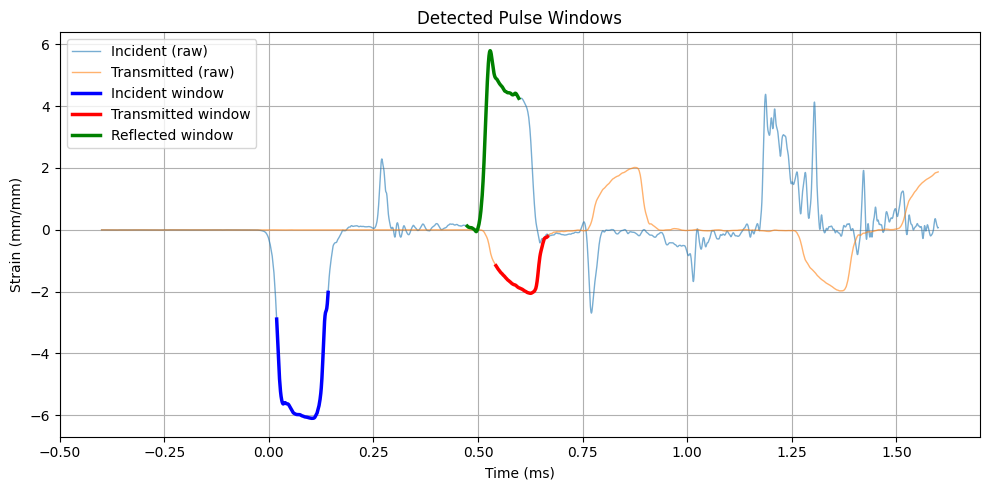

Window lengths:
  Incident: 9844 samples
  Transmitted: 9844 samples
  Reflected: 9844 samples


In [99]:
# Visualize detected windows
i0, i1 = incident_window
t0, t1 = transmitted_window
r0, r1 = reflected_window

fig, ax = plt.subplots(figsize=(10, 5))

# Full raw traces
ax.plot(raw_df["time"], raw_df["incident"], lw=1, alpha=0.6, label="Incident (raw)")
ax.plot(raw_df["time"], raw_df["transmitted"], lw=1, alpha=0.6, label="Transmitted (raw)")

# Highlight detected windows
ax.plot(raw_df["time"].iloc[i0:i1], raw_df["incident"].iloc[i0:i1],
        lw=2.5, label="Incident window", c="blue")
ax.plot(raw_df["time"].iloc[t0:t1], raw_df["transmitted"].iloc[t0:t1],
        lw=2.5, label="Transmitted window", c="red")
ax.plot(raw_df["time"].iloc[r0:r1], raw_df["incident"].iloc[r0:r1],
        lw=2.5, label="Reflected window", c="green")

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Strain (mm/mm)")
ax.set_title("Detected Pulse Windows")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

print(f"Window lengths:")
print(f"  Incident: {i1-i0} samples")
print(f"  Transmitted: {t1-t0} samples")
print(f"  Reflected: {r1-r0} samples")

## Center and Segment Pulses

In [100]:
# Define number of points for centered segments
n_pts = 25000
thresh_ratio = 0

# Segment and center incident pulse
inc_seg = detector.segment_and_center(
    raw_df["incident"].values,
    incident_window,
    n_points=n_pts,
    polarity="compressive",
    thresh_ratio=thresh_ratio,  # Set to 0 to keep all data (no noise suppression)
    debug=True
)

# Segment and center transmitted pulse
trs_seg = transmitted_detector.segment_and_center(
    raw_df["transmitted"].values,
    transmitted_window,
    n_points=n_pts,
    polarity="compressive",
    thresh_ratio=thresh_ratio,
    debug=True
)

# Segment and center reflected pulse
ref_seg = reflected_detector.segment_and_center(
    raw_df["incident"].values,  # Reflected is in incident channel
    reflected_window,
    n_points=n_pts,
    polarity="tensile",
    thresh_ratio=thresh_ratio,
    debug=True
)

# Store segmentation metadata
test_metadata.segment_n_points = int(n_pts)
test_metadata.segment_thresh_ratio = float(thresh_ratio)
# Note: centering_shift values would need to be extracted from segment_and_center
# if the function is modified to return them, or calculated from the centering process
# For now, these are not stored but could be added if needed

print(f"\nSegmentation metadata:")
print(f"  N points: {test_metadata.segment_n_points}")
print(f"  Threshold ratio: {test_metadata.segment_thresh_ratio}")
print(f"  Segment shapes: inc={inc_seg.shape}, trs={trs_seg.shape}, ref={ref_seg.shape}")

[segment_and_center] shift = +205 points
[segment_and_center] shift = +471 points
[segment_and_center] shift = -2414 points

Segmentation metadata:
  N points: 25000
  Threshold ratio: 0.0
  Segment shapes: inc=(25000,), trs=(25000,), ref=(25000,)


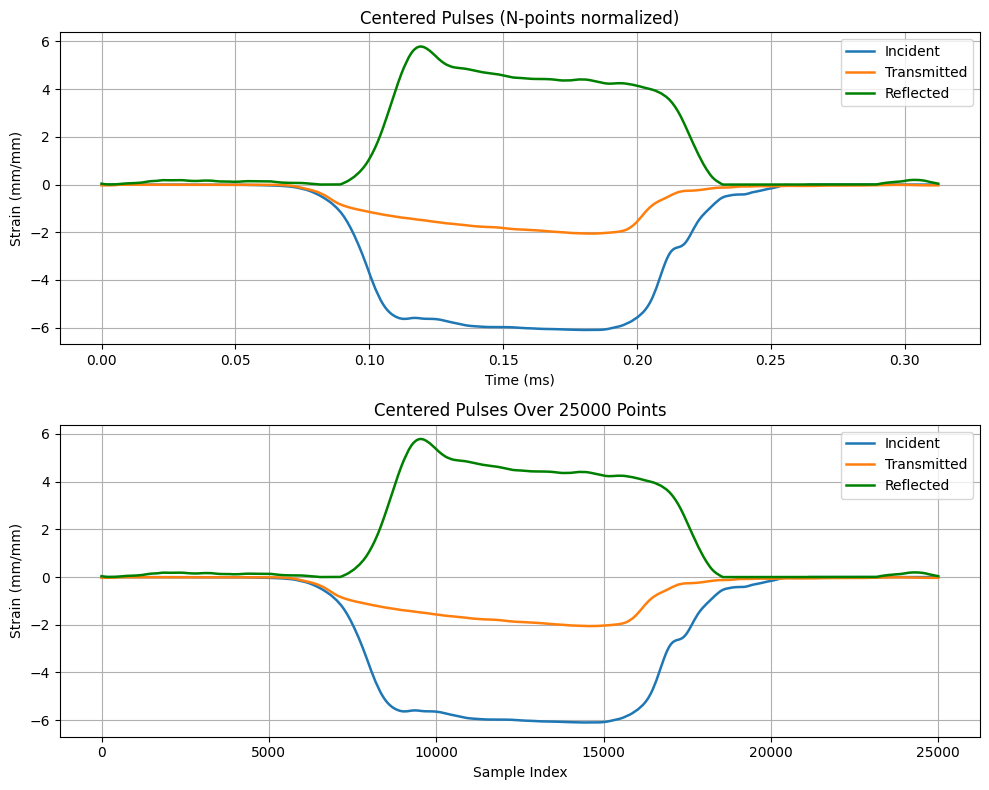


Segment shapes:
  Incident: (25000,)
  Transmitted: (25000,)
  Reflected: (25000,)


In [101]:
# Visualize centered pulses
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Time axis for centered pulses
time_seg = np.arange(n_pts) * dt

# Plot 1: Centered pulses vs time
ax1.plot(time_seg, inc_seg, label="Incident", lw=1.8)
ax1.plot(time_seg, trs_seg, label="Transmitted", lw=1.8)
ax1.plot(time_seg, ref_seg, label="Reflected", lw=1.8, c="green")
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Strain (mm/mm)")
ax1.set_title("Centered Pulses (N-points normalized)")
ax1.legend()
ax1.grid()

# Plot 2: Centered pulses vs sample index
ax2.plot(inc_seg, label="Incident", lw=1.8)
ax2.plot(trs_seg, label="Transmitted", lw=1.8)
ax2.plot(ref_seg, label="Reflected", lw=1.8, c="green")
ax2.set_xlabel("Sample Index")
ax2.set_ylabel("Strain (mm/mm)")
ax2.set_title(f"Centered Pulses Over {n_pts} Points")
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

print(f"\nSegment shapes:")
print(f"  Incident: {inc_seg.shape}")
print(f"  Transmitted: {trs_seg.shape}")
print(f"  Reflected: {ref_seg.shape}")

## Align Pulse Fronts

In [186]:
# Optimization weights for fitness function
# These control the relative importance of each equilibrium criterion
opt_weights = {
    'corr': 0.3,   # Pulse correlation
    'u': 0.3,      # Bar displacement equilibrium
    'sr': 0.3,     # Strain rate equilibrium
    'e': 0.1       # Strain equilibrium
}

# Create PulseAligner instance
aligner = PulseAligner(
    bar_wave_speed=bar_wave_speed,
    specimen_height=specimen_height,
    k_linear=0.35,  # Use 35% of steepest slope to define linear region
    weights=opt_weights
)

# Define search bounds for optimization
# These constrain where the algorithm looks for optimal shifts
# Adjust based on your experimental setup and expected pulse timing
t_min = 1500
t_max = 1550
r_min = -800
r_max = -300

search_bounds_t = (t_min, t_max)
search_bounds_r = (r_min, r_max)

print(f"PulseAligner initialized:")
print(f"  k_linear: {aligner.k_linear}")
print(f"  Search bounds transmitted: {search_bounds_t}")
print(f"  Search bounds reflected: {search_bounds_r}")

# Run alignment optimization
print(f"\nRunning alignment optimization...")
inc_aligned, trs_aligned, ref_aligned, shift_t, shift_r = aligner.align(
    incident=inc_seg,
    transmitted=trs_seg,
    reflected=ref_seg,
    time_vector=time_seg,
    search_bounds_t=search_bounds_t,
    search_bounds_r=search_bounds_r,
    debug=False  # Set to False to suppress optimization output
)

print(f"\n{'='*60}")
print(f"Alignment complete!")
print(f"  Transmitted shift: {shift_t:+d} samples")
print(f"  Reflected shift: {shift_r:+d} samples")
print(f"{'='*60}")

# Store alignment configuration and results
test_metadata.k_linear = aligner.k_linear
test_metadata.alignment_weight_corr = aligner.weights['corr']
test_metadata.alignment_weight_u = aligner.weights['u']
test_metadata.alignment_weight_sr = aligner.weights['sr']
test_metadata.alignment_weight_e = aligner.weights['e']
test_metadata.search_bounds_t_min = int(t_min)
test_metadata.search_bounds_t_max = int(t_max)
test_metadata.search_bounds_r_min = int(r_min)
test_metadata.search_bounds_r_max = int(r_max)
test_metadata.shift_transmitted = int(shift_t)
test_metadata.shift_reflected = int(shift_r)
# Note: linear_region_start/end are stored in aligner and could be extracted if needed

print(f"\nAlignment metadata stored:")
print(f"  k_linear: {test_metadata.k_linear}")
print(f"  Weights: corr={test_metadata.alignment_weight_corr}, u={test_metadata.alignment_weight_u}, sr={test_metadata.alignment_weight_sr}, e={test_metadata.alignment_weight_e}")
print(f"  Shifts: T={test_metadata.shift_transmitted}, R={test_metadata.shift_reflected}")

PulseAligner initialized:
  k_linear: 0.35
  Search bounds transmitted: (1500, 1550)
  Search bounds reflected: (-800, -300)

Running alignment optimization...

Alignment complete!
  Transmitted shift: +1549 samples
  Reflected shift: -769 samples

Alignment metadata stored:
  k_linear: 0.35
  Weights: corr=0.3, u=0.3, sr=0.3, e=0.1
  Shifts: T=1549, R=-769


In [187]:
# Build time axis centered on incident pulse rise
# Find the rise front (8% threshold of max amplitude)
front_thresh = 0.08
inc_abs = np.abs(inc_aligned)
front_idx = np.argmax(inc_abs > front_thresh * inc_abs.max())

# Create time axis with t=0 at the rise front
time_aligned = (np.arange(n_pts) - front_idx) * dt

print(f"Time axis centered on incident rise:")
print(f"  Rise front index: {front_idx}")
print(f"  Time range: [{time_aligned[0]:.3f}, {time_aligned[-1]:.3f}] ms")
print(f"  Zero crossing at sample {front_idx}")

# Store front index and linear region info in metadata
test_metadata.front_thresh = float(front_thresh)
test_metadata.alignment_front_idx = int(front_idx)
# Extract linear region indices from aligner if available
if hasattr(aligner, 'linear_start') and hasattr(aligner, 'linear_end'):
    test_metadata.linear_region_start = aligner.linear_start
    test_metadata.linear_region_end = aligner.linear_end
    print(f"  Linear region: [{test_metadata.linear_region_start}, {test_metadata.linear_region_end}]")

Time axis centered on incident rise:
  Rise front index: 6557
  Time range: [-0.082, 0.231] ms
  Zero crossing at sample 6557


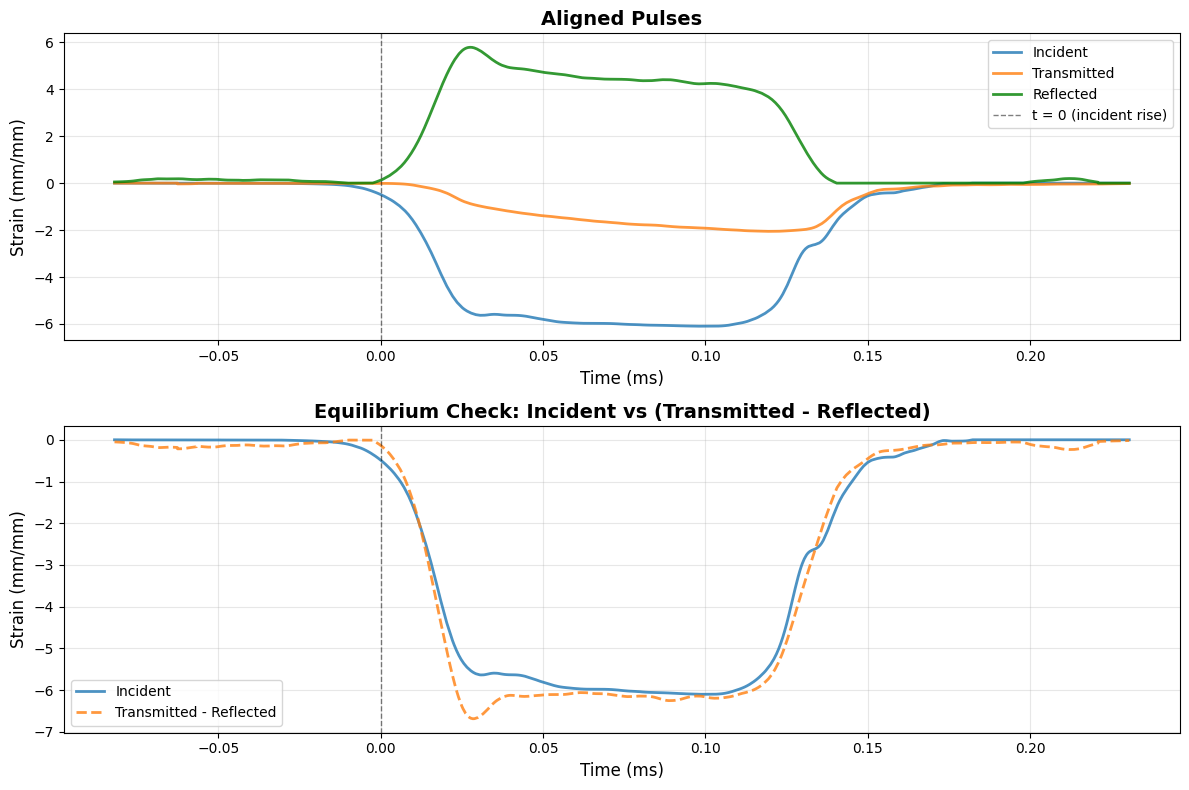


Equilibrium correlation:
  Pearson r = 0.9956 (p-value: 0.00e+00)


In [188]:
# Visualize aligned pulses
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Aligned pulses
ax1.plot(time_aligned, inc_aligned, lw=2.0, label="Incident", alpha=0.8)
ax1.plot(time_aligned, trs_aligned, lw=2.0, label="Transmitted", alpha=0.8)
ax1.plot(time_aligned, ref_aligned, lw=2.0, label="Reflected", c="green", alpha=0.8)
ax1.axvline(0, ls="--", c="k", lw=1, alpha=0.5, label="t = 0 (incident rise)")
ax1.set_xlabel("Time (ms)", fontsize=12)
ax1.set_ylabel("Strain (mm/mm)", fontsize=12)
ax1.set_title("Aligned Pulses", fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(alpha=0.3)

# Plot 2: Check equilibrium (incident vs transmitted - reflected)
equilibrium_check = trs_aligned - ref_aligned
ax2.plot(time_aligned, inc_aligned, lw=2.0, label="Incident", alpha=0.8)
ax2.plot(time_aligned, equilibrium_check, lw=2.0, label="Transmitted - Reflected",
         alpha=0.8, ls='--')
ax2.axvline(0, ls="--", c="k", lw=1, alpha=0.5)
ax2.set_xlabel("Time (ms)", fontsize=12)
ax2.set_ylabel("Strain (mm/mm)", fontsize=12)
ax2.set_title("Equilibrium Check: Incident vs (Transmitted - Reflected)",
              fontsize=14, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and display correlation coefficient
from scipy.stats import pearsonr
# Use only the region where both signals are non-zero
mask = (np.abs(inc_aligned) > 1e-6) & (np.abs(equilibrium_check) > 1e-6)
if mask.sum() > 0:
    corr, pval = pearsonr(inc_aligned[mask], equilibrium_check[mask])
    print(f"\nEquilibrium correlation:")
    print(f"  Pearson r = {corr:.4f} (p-value: {pval:.2e})")

## Calculate Stress-Strain Curves

In [189]:
# Strain scale factor for converting gauge output to dimensionless strain
# Default is 1e4 (assumes gauge output where 10000 = 1.0 strain)
strain_scale_factor = 1

# Create StressStrainCalculator instance with strain scale factor
calculator = StressStrainCalculator(
    bar_area=bar_cross_section,
    bar_wave_speed=bar_wave_speed,
    bar_elastic_modulus=bar_elastic_modulus,
    specimen_area=specimen_cross_section,
    specimen_height=specimen_height,
    strain_scale_factor=strain_scale_factor,
    use_voltage_input=True,
    incident_reflected_gauge_params = incident_reflected_gauge_params,
    transmitted_gauge_params = transmitted_gauge_params
)

print(f"\nStressStrainCalculator initialized:")
print(f"  Area ratio: {calculator.area_ratio:.3f}")


StressStrainCalculator initialized:
  Area ratio: 2.215


In [190]:
# Calculate stress-strain curves using all three methods
all_results = calculator.calculate(
    incident=inc_aligned,
    transmitted=trs_aligned,
    reflected=ref_aligned,
    time_vector=time_aligned
)

# Extract results for each method
time = all_results['time']
stress_1w = all_results["stress_1w"]
true_stress_1w = all_results["true_stress_1w"]
strain_1w = all_results["strain_1w"]
true_strain_1w = all_results["true_strain_1w"]
strain_rate_1w = all_results["strain_rate_1w"]
true_strain_rate_1w = all_results["true_strain_rate_1w"]

stress_3w = all_results["stress_3w"]
true_stress_3w = all_results["true_stress_3w"]
strain_3w = all_results["strain_3w"]
true_strain_3w = all_results["true_strain_3w"]
strain_rate_3w = all_results["strain_rate_3w"]
true_strain_rate_3w = all_results["true_strain_rate_3w"]

force_1w = all_results["bar_force_1w"]
# Calculate rise time
inc_rise_time = detector.calculate_rise_time(inc_aligned, time_aligned)

# Store rise time in metadata
test_metadata.incident_rise_time = {
    'value': inc_rise_time,
    'unit': 'unit:MilliSEC',
    'reference_unit': 'unit:MilliSEC'
}

print("Stress-strain calculation complete!")
print(f"\nData shapes (all methods):")
print(f"  Time: {time.shape}")
print(f"  Stress: {stress_1w.shape}")
print(f"  Strain: {strain_1w.shape}")
print(f"  Strain rate: {strain_rate_1w.shape}")

print(f"\nPeak values (1-wave method):")
print(f"  Max stress: {stress_1w.max():.2f} MPa")
print(f"  Max strain: {strain_1w.max():.4f}")
print(f"  Max strain rate: {strain_rate_1w.max():.2f} 1/s")
print(f"  Inc rise time: {test_metadata.incident_rise_time['value']:.4f} ms")

Stress-strain calculation complete!

Data shapes (all methods):
  Time: (25000,)
  Stress: (25000,)
  Strain: (25000,)
  Strain rate: (25000,)

Peak values (1-wave method):
  Max stress: 441.71 MPa
  Max strain: 0.4045
  Max strain rate: 4344.85 1/s
  Inc rise time: 0.0224 ms


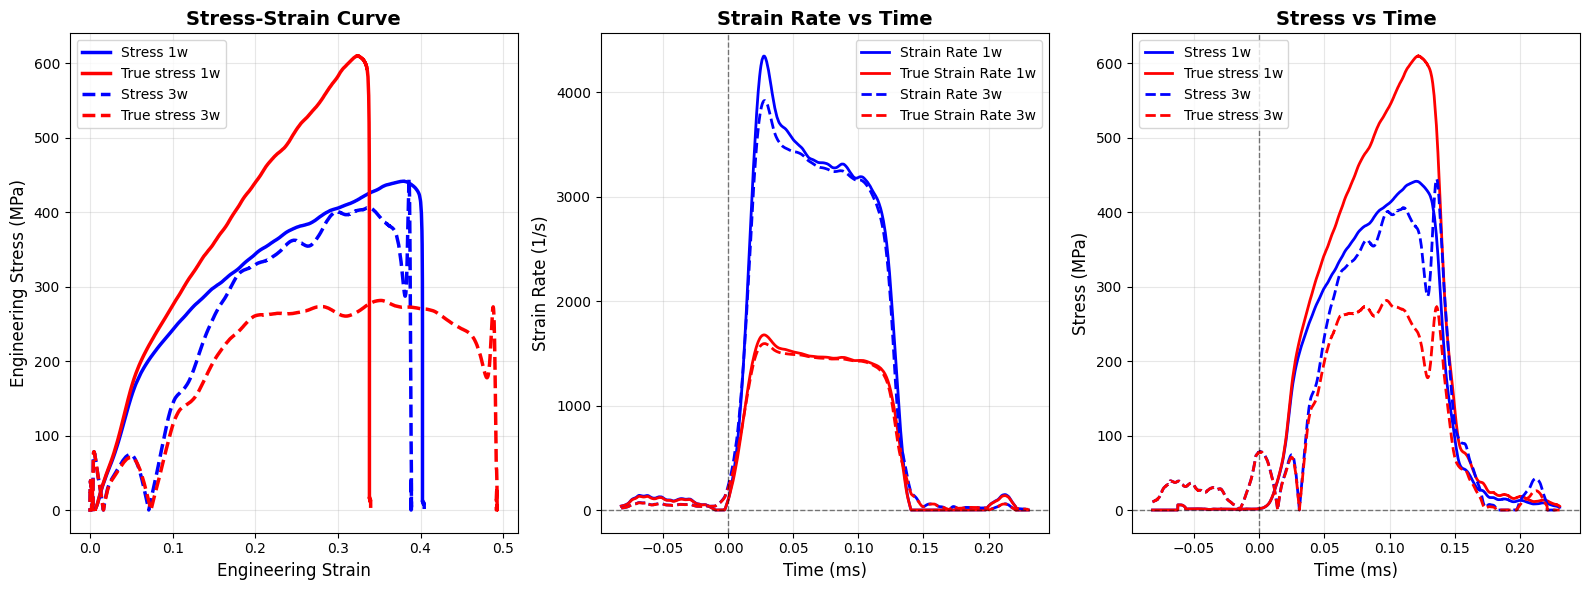

In [191]:
# Visualize stress-strain curve
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

# Plot 1: Stress-Strain curve (1-wave method)
ax1.plot(strain_1w, stress_1w, lw=2.5, color='blue', label='Stress 1w')
ax1.plot(true_strain_1w, true_stress_1w, lw=2.5, color='red', label='True stress 1w')
ax1.plot(strain_3w, stress_3w, lw=2.5, ls="--", color='blue', label='Stress 3w')
ax1.plot(true_strain_3w, true_stress_3w, lw=2.5, ls="--", color='red', label='True stress 3w')
ax1.set_xlabel('Engineering Strain', fontsize=12)
ax1.set_ylabel('Engineering Stress (MPa)', fontsize=12)
ax1.set_title('Stress-Strain Curve', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Strain rate vs time
ax2.plot(time, strain_rate_1w, lw=2.0, color='blue', label='Strain Rate 1w')
ax2.plot(time, true_strain_rate_1w, lw=2.0, color='red', label='True Strain Rate 1w')
ax2.plot(time, strain_rate_3w, lw=2.0, ls="--", color='blue', label='Strain Rate 3w')
ax2.plot(time, true_strain_rate_3w, lw=2.0, ls="--", color='red', label='True Strain Rate 3w')
ax2.axhline(0, ls='--', c='k', lw=1, alpha=0.5)
ax2.axvline(0, ls='--', c='k', lw=1, alpha=0.5)
ax2.set_xlabel('Time (ms)', fontsize=12)
ax2.set_ylabel('Strain Rate (1/s)', fontsize=12)
ax2.set_title('Strain Rate vs Time', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Stress vs time
ax3.plot(time, stress_1w, lw=2.0, color='blue', label='Stress 1w')
ax3.plot(time, true_stress_1w, lw=2.0, color='red', label='True stress 1w')
ax3.plot(time, stress_3w, lw=2.0, ls="--", color='blue', label='Stress 3w')
ax3.plot(time, true_stress_3w, lw=2.0, ls="--", color='red', label='True stress 3w')
ax3.axhline(0, ls='--', c='k', lw=1, alpha=0.5)
ax3.axvline(0, ls='--', c='k', lw=1, alpha=0.5)
ax3.set_xlabel('Time (ms)', fontsize=12)
ax3.set_ylabel('Stress (MPa)', fontsize=12)
ax3.set_title('Stress vs Time', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Equilibrium Metrics

In [192]:
# Calculate equilibrium metrics
metrics = calculator.calculate_equilibrium_metrics(all_results)

print("\n" + "="*60)
print("EQUILIBRIUM ASSESSMENT METRICS")
print("="*60)

print("\n--- Overall Metrics ---")
print(f"Force Balance Coefficient (FBC):        {metrics['FBC']:.4f}  (target: >0.95)")
print(f"Stress Equilibrium Quality Index (SEQI): {metrics['SEQI']:.4f}  (target: >0.90)")
print(f"Stress Oscillation Index (SOI):         {metrics['SOI']:.4f}  (target: <0.05)")
print(f"Dynamic Stress Uniformity Factor (R²):  {metrics['DSUF']:.4f}  (target: >0.98)")

print("\n--- Phase-Specific Metrics ---")
print("Loading Phase (0-50% peak stress):")
print(f"  FBC:  {metrics['windowed_FBC_loading']:.4f}")
print(f"  R²:   {metrics['windowed_DSUF_loading']:.4f}")

print("\nPlateau Phase (50-100% peak stress):")
print(f"  FBC:  {metrics['windowed_FBC_plateau']:.4f}")
print(f"  R²:   {metrics['windowed_DSUF_plateau']:.4f}")

print("\nUnloading Phase (after peak):")
print(f"  FBC:  {metrics['windowed_FBC_unloading']:.4f}")
print(f"  R²:   {metrics['windowed_DSUF_unloading']:.4f}")

print("="*60)

# Store equilibrium metrics in metadata
test_metadata.fbc = metrics['FBC']
test_metadata.seqi = metrics['SEQI']
test_metadata.soi = metrics['SOI']
test_metadata.dsuf = metrics['DSUF']
test_metadata.fbc_loading = metrics['windowed_FBC_loading']
test_metadata.dsuf_loading = metrics['windowed_DSUF_loading']
test_metadata.fbc_plateau = metrics['windowed_FBC_plateau']
test_metadata.dsuf_plateau = metrics['windowed_DSUF_plateau']
test_metadata.fbc_unloading = metrics['windowed_FBC_unloading']
test_metadata.dsuf_unloading = metrics['windowed_DSUF_unloading']

print(f"\nEquilibrium metrics stored in metadata")


EQUILIBRIUM ASSESSMENT METRICS

--- Overall Metrics ---
Force Balance Coefficient (FBC):        0.6794  (target: >0.95)
Stress Equilibrium Quality Index (SEQI): 0.8698  (target: >0.90)
Stress Oscillation Index (SOI):         0.0543  (target: <0.05)
Dynamic Stress Uniformity Factor (R²):  0.8828  (target: >0.98)

--- Phase-Specific Metrics ---
Loading Phase (0-50% peak stress):
  FBC:  0.4937
  R²:   0.5362

Plateau Phase (50-100% peak stress):
  FBC:  0.8843
  R²:   0.4008

Unloading Phase (after peak):
  FBC:  0.5853
  R²:   0.9824

Equilibrium metrics stored in metadata


## Apply Tukey Window

In [193]:
# Create TukeyWindow instances with different alpha values
tukey = TukeyWindow(alpha=0.78)  # 50% tapering (recommended)

# Apply Tukey window to aligned pulses (using alpha=0.5 for ML preprocessing)
inc_tapered = tukey.apply(inc_aligned)
trs_tapered = tukey.apply(trs_aligned)
ref_tapered = tukey.apply(ref_aligned)

# Store Tukey window parameter in metadata
test_metadata.tukey_alpha = tukey.alpha

print(f"Tukey window applied (α={test_metadata.tukey_alpha}):")
print(f"  Incident: {inc_aligned.shape} → {inc_tapered.shape}")
print(f"  Transmitted: {trs_aligned.shape} → {trs_tapered.shape}")
print(f"  Reflected: {ref_aligned.shape} → {ref_tapered.shape}")

# Compare energy before and after tapering
energy_before = np.sum(inc_aligned**2)
energy_after = np.sum(inc_tapered**2)
energy_loss = 100 * (1 - energy_after/energy_before)

print(f"\nEnergy analysis (incident pulse):")
print(f"  Energy before tapering: {energy_before:.2e}")
print(f"  Energy after tapering: {energy_after:.2e}")
print(f"  Energy loss: {energy_loss:.2f}%")

Tukey window applied (α=0.78):
  Incident: (25000,) → (25000,)
  Transmitted: (25000,) → (25000,)
  Reflected: (25000,) → (25000,)

Energy analysis (incident pulse):
  Energy before tapering: 3.02e+05
  Energy after tapering: 2.96e+05
  Energy loss: 2.07%


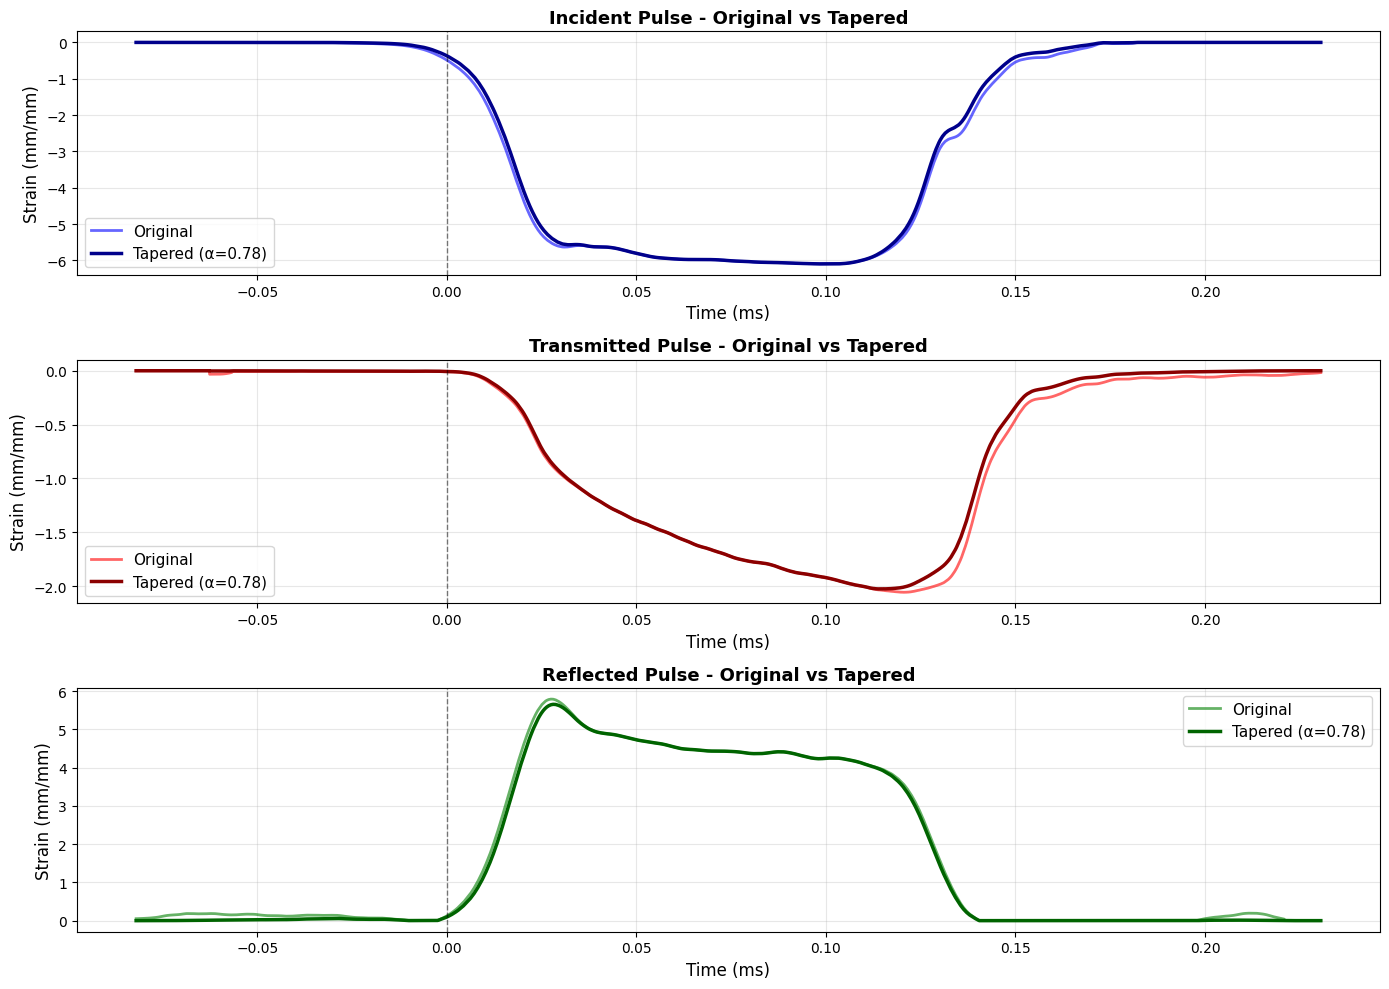

In [194]:
# Visualize effect of Tukey window on pulses
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Incident pulse
axes[0].plot(time_aligned, inc_aligned, lw=2.0, alpha=0.6, label='Original', color='blue')
axes[0].plot(time_aligned, inc_tapered, lw=2.5, label=f'Tapered (α={test_metadata.tukey_alpha})', color='darkblue')
axes[0].axvline(0, ls='--', c='k', lw=1, alpha=0.5)
axes[0].set_xlabel('Time (ms)', fontsize=12)
axes[0].set_ylabel('Strain (mm/mm)', fontsize=12)
axes[0].set_title('Incident Pulse - Original vs Tapered', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Transmitted pulse
axes[1].plot(time_aligned, trs_aligned, lw=2.0, alpha=0.6, label='Original', color='red')
axes[1].plot(time_aligned, trs_tapered, lw=2.5, label=f'Tapered (α={test_metadata.tukey_alpha})', color='darkred')
axes[1].axvline(0, ls='--', c='k', lw=1, alpha=0.5)
axes[1].set_xlabel('Time (ms)', fontsize=12)
axes[1].set_ylabel('Strain (mm/mm)', fontsize=12)
axes[1].set_title('Transmitted Pulse - Original vs Tapered', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

# Reflected pulse
axes[2].plot(time_aligned, ref_aligned, lw=2.0, alpha=0.6, label='Original', color='green')
axes[2].plot(time_aligned, ref_tapered, lw=2.5, label=f'Tapered (α={test_metadata.tukey_alpha})', color='darkgreen')
axes[2].axvline(0, ls='--', c='k', lw=1, alpha=0.5)
axes[2].set_xlabel('Time (ms)', fontsize=12)
axes[2].set_ylabel('Strain (mm/mm)', fontsize=12)
axes[2].set_title('Reflected Pulse - Original vs Tapered', fontsize=13, fontweight='bold')
axes[2].legend(fontsize=11)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Test Validity / Notes

In [195]:
print("=" * 60)
print("VALIDITY ASSESSMENT")
print("=" * 60)

# Extract metrics for display
fbc = metrics['FBC']
seqi = metrics['SEQI']
soi = metrics['SOI']
dsuf = metrics['DSUF']

# Assess validity from equilibrium metrics (sets test_validity and validity_criteria)
test_metadata.assess_validity_from_metrics(metrics)

print(f"\nTest Validity Status: {test_metadata.test_validity}")
print(f"Specific Criteria Met: {test_metadata.validity_criteria if test_metadata.validity_criteria else 'None'}")
print(f"\nValidity Notes:")
print(f"  {test_metadata.validity_notes}")

print("\n" + "=" * 60)
print("VALIDITY ASSESSMENT DETAILS")
print("=" * 60)

# Force equilibrium assessment
if fbc >= 0.90 and dsuf >= 0.90:
  force_eq_status = "  ACHIEVED"
elif fbc >= 0.75 or dsuf >= 0.75:
  force_eq_status = "  PARTIALLY ACHIEVED"
else:
  force_eq_status = "  NOT ACHIEVED"

# Strain rate assessment
if soi <= 0.10:
  strain_rate_status = "  ACHIEVED"
elif soi <= 0.20:
  strain_rate_status = "  PARTIALLY ACHIEVED"
else:
  strain_rate_status = "  NOT ACHIEVED"

print(f"\nForce Equilibrium: {force_eq_status}")
print(f"  FBC: {fbc:.4f} (target: ≥0.90)")
print(f"  DSUF: {dsuf:.4f} (target: ≥0.90)")
if 'dyn:ForceEquilibrium' in (test_metadata.validity_criteria or []):
  print("  ✓ Criterion met: dyn:ForceEquilibrium")

print(f"\nConstant Strain Rate: {strain_rate_status}")
print(f"  SOI: {soi:.4f} (target: ≤0.10)")
if 'dyn:ConstantStrainRate' in (test_metadata.validity_criteria or []):
  print("  ✓ Criterion met: dyn:ConstantStrainRate")

print(f"\nStress Equilibrium Quality:")
print(f"  SEQI: {seqi:.4f} (target: ≥0.90)")

print("\n" + "=" * 60)
print("CRITERIA SUMMARY")
print("=" * 60)

# Count passing criteria
strict_pass = sum([
  fbc >= 0.95,
  seqi >= 0.90,
  soi <= 0.05,
  dsuf >= 0.98
])

relaxed_pass = sum([
  fbc >= 0.85,
  seqi >= 0.80,
  soi <= 0.10,
  dsuf >= 0.90
])

print(f"Strict criteria passed: {strict_pass}/4 (all must pass for VALID)")
print(f"  FBC ≥ 0.95:   {'✓' if fbc >= 0.95 else '✗'}")
print(f"  SEQI ≥ 0.90:  {'✓' if seqi >= 0.90 else '✗'}")
print(f"  SOI ≤ 0.05:   {'✓' if soi <= 0.05 else '✗'}")
print(f"  DSUF ≥ 0.98:  {'✓' if dsuf >= 0.98 else '✗'}")

print(f"\nRelaxed criteria passed: {relaxed_pass}/4 (≥2 needed for QUESTIONABLE)")
print(f"  FBC ≥ 0.85:   {'✓' if fbc >= 0.85 else '✗'}")
print(f"  SEQI ≥ 0.80:  {'✓' if seqi >= 0.80 else '✗'}")
print(f"  SOI ≤ 0.10:   {'✓' if soi <= 0.10 else '✗'}")
print(f"  DSUF ≥ 0.90:  {'✓' if dsuf >= 0.90 else '✗'}")

# Display final verdict using convenience methods
print("\n" + "=" * 60)
if test_metadata.is_valid():
  print(" TEST VALID - All strict criteria passed, data meets quality standards")
elif test_metadata.is_questionable():
  print(" TEST QUESTIONABLE - At least 2 relaxed criteria passed, review carefully")
else:
  print(" TEST INVALID - Less than 2 relaxed criteria passed")
print("=" * 60)


VALIDITY ASSESSMENT

Test Validity Status: dyn:QuestionableTest
Specific Criteria Met: ['dyn:ConstantStrainRate']

Validity Notes:
  Force equilibrium partially achieved (FBC=0.679, DSUF=0.883); Constant strain rate maintained (SOI=0.054); Acceptable stress equilibrium (SEQI=0.870)

VALIDITY ASSESSMENT DETAILS

Force Equilibrium:   PARTIALLY ACHIEVED
  FBC: 0.6794 (target: ≥0.90)
  DSUF: 0.8828 (target: ≥0.90)

Constant Strain Rate:   ACHIEVED
  SOI: 0.0543 (target: ≤0.10)
  ✓ Criterion met: dyn:ConstantStrainRate

Stress Equilibrium Quality:
  SEQI: 0.8698 (target: ≥0.90)

CRITERIA SUMMARY
Strict criteria passed: 0/4 (all must pass for VALID)
  FBC ≥ 0.95:   ✗
  SEQI ≥ 0.90:  ✗
  SOI ≤ 0.05:   ✗
  DSUF ≥ 0.98:  ✗

Relaxed criteria passed: 2/4 (≥2 needed for QUESTIONABLE)
  FBC ≥ 0.85:   ✗
  SEQI ≥ 0.80:  ✓
  SOI ≤ 0.10:   ✓
  DSUF ≥ 0.90:  ✗

 TEST QUESTIONABLE - At least 2 relaxed criteria passed, review carefully


In [196]:
test_metadata.test_type = "dyn:SpecimenTest"


## RDF Parsing

In [197]:
# Update analysis timestamp and data series references
from datetime import datetime

test_metadata.analysis_timestamp = datetime.now().isoformat()

# Set data series URIs (will be created by writer)
test_metadata.data_series_time_uri = f'dyn:{test_id.replace("-", "_")}_time'
test_metadata.data_series_incident_uri = f'dyn:{test_id.replace("-", "_")}_incident'
test_metadata.data_series_transmitted_uri = f'dyn:{test_id.replace("-", "_")}_transmitted'

# Set processing object URIs (will be created by writer)
test_metadata.incident_window_uri = f'dyn:{test_id.replace("-", "_")}_inc_window'
test_metadata.transmitted_window_uri = f'dyn:{test_id.replace("-", "_")}_trs_window'
test_metadata.reflected_window_uri = f'dyn:{test_id.replace("-", "_")}_ref_window'
test_metadata.transmitted_shift_uri = f'dyn:{test_id.replace("-", "_")}_trs_shift'
test_metadata.reflected_shift_uri = f'dyn:{test_id.replace("-", "_")}_ref_shift'
test_metadata.incident_detection_params_uri = f'dyn:{test_id.replace("-", "_")}_inc_detect'
test_metadata.transmitted_detection_params_uri = f'dyn:{test_id.replace("-", "_")}_trs_detect'
test_metadata.reflected_detection_params_uri = f'dyn:{test_id.replace("-", "_")}_ref_detect'
test_metadata.alignment_params_uri = f'dyn:{test_id.replace("-", "_")}_alignment'
test_metadata.equilibrium_metrics_uri = f'dyn:{test_id.replace("-", "_")}_equilibrium'

print("="*60)
print("METADATA SUMMARY")
print("="*60)
print(f"Analysis timestamp: {test_metadata.analysis_timestamp}")
print(f"Data series URIs: {test_metadata.data_series_time_uri}, {test_metadata.data_series_incident_uri}, {test_metadata.data_series_transmitted_uri}")
print(f"Processing object URIs created: 10 instances")
print("="*60)

# Ingest test with full provenance, including processed results
writer = SHPBTestWriter(ontology_manager, qudt_manager)
test_path, validation = writer.ingest_test(
    test_metadata,
    raw_df,
    processed_results=all_results  # Pass processed data for DataSeries creation
)

if test_path:
    print(f"\n✓ Test saved with complete provenance: {test_path}")
    print(f"  - Raw DataSeries: 3 instances (time, incident, transmitted)")
    print(f"  - Processed DataSeries: {len(all_results)} instances (stress, strain, etc.)")
    if validation.has_any_issues():
        print(f"  - Validation warnings: {validation.get_summary()}")
else:
    print(f"\n✗ Ingestion failed: {validation.get_summary()}")

METADATA SUMMARY
Analysis timestamp: 2026-01-15T21:48:59.115870
Data series URIs: dyn:DYNML_SS316A356_0003_SHPBTest_time, dyn:DYNML_SS316A356_0003_SHPBTest_incident, dyn:DYNML_SS316A356_0003_SHPBTest_transmitted
Processing object URIs created: 10 instances

✓ Test saved with complete provenance: D:\DynaMat-Platform\user_data\specimens\DYNML-SS316A356-0003\DYNML_SS316A356_0003_SHPBTest.ttl
  - Raw DataSeries: 3 instances (time, incident, transmitted)
  - Processed DataSeries: 20 instances (stress, strain, etc.)


In [262]:

# Display detailed validation violations
if validation.has_blocking_issues():
    print("="*60)
    print("DETAILED VALIDATION VIOLATIONS")
    print("="*60)
    for i, issue in enumerate(validation.violations, 1):
        print(f"\n{i}. {issue.get_display_message()}")
        if issue.focus_node:
            print(f"   Focus node: {issue.focus_node}")
        if issue.source_shape:
            print(f"   Shape: {issue.source_shape}")
    print("="*60)